<a href="https://colab.research.google.com/github/JJang-likit/GoingDeeper_Aiffel/blob/main/GoingDeeper_Making_CAM%2C_Grad_CAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GoingDeeper / Project CAM을 만들고 평가해보자

## 목차

- 데이터셋 준비
- CAM을 위한 모델 구성 및 학습하기
- CAM 생성하기
- Grad - CAM 생성하기
- 바운딩 박스 만들기
- loU 구하기
- 정리 및 회고

### 프로젝트에 사용할 데이터셋 준비하기

In [1]:
# 사용할 라이브러리 불러오기

import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

import copy
import cv2
from PIL import Image

In [2]:
# GPU 확인

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
# 데이터셋 다운로드

(ds_train, ds_test), ds_info = tfds.load('stanford_dogs', split = ['train', 'test'], shuffle_files = True, with_info = True)
print('완료')

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incompleteZ19QAJ/stanford_dogs-train.tfrecord


  0%|          | 0/12000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incompleteZ19QAJ/stanford_dogs-test.tfrecord


  0%|          | 0/8580 [00:00<?, ? examples/s]

Dataset stanford_dogs downloaded and prepared to /root/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.
완료


### CAM을 위한 모델 구성 및 학습하기

In [4]:
# Making Model / ResNet-50

num_classes = ds_info.features["label"].num_classes
base_model = keras.applications.resnet50.ResNet50(include_top = False, weights = 'imagenet', input_shape = (224,224,3), pooling = 'avg')
x = base_model.output
preds = keras.layers.Dense(num_classes, activation = 'softmax')(x)
cam_model = keras.Model(inputs = base_model.input, outputs = preds)

print('모델구성완료')

94781440/94765736 [==============================] - 1s 0us/step
모델구성완료


In [5]:
# 모델 학습을 위한 정규화 및 전처리 과정

def normalize_and_resize_img(input):
  image = tf.image.resize(input['image'], [224,224]) # 정규화 과정 uint8 -> float32
  input['image'] = tf.cast(image, tf.float32) / 255.
  return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test = False, batch_size = 16):
  ds = ds.map(normalize_and_resize_img, num_parallel_calls = 2)
  ds = ds.batch(batch_size)
  if not is_test : 
    ds = ds.repeat()
    ds = ds.shuffle(200)
  ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
  return ds

print('모델 훈련 준비 완료')

모델 훈련 준비 완료


In [6]:
# 데이터셋에 전처리 과정 적용

ds_train_norm = apply_normalize_on_dataset(ds_train)
ds_test_norm = apply_normalize_on_dataset(ds_test)

for input in ds_train_norm.take(1):
  image, label = input
  print(image.shape)
  print(label.shape)

(16, 224, 224, 3)
(16,)


In [7]:
# Model Compile

cam_model.compile(loss = 'sparse_categorical_crossentropy', optimizer = tf.keras.optimizers.SGD(lr = 0.01), metrics = ['accuracy'])
print('준비 완료')

준비 완료


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [8]:
# 모델 훈련 / 10epoch 훈련

history_cam_model = cam_model.fit(
    ds_train_norm,
    steps_per_epoch = int(ds_info.splits['train'].num_examples/16),
    validation_steps = int(ds_info.splits['test'].num_examples/16),
    epochs = 10,
    validation_data = ds_test_norm,
    verbose = 1,
    use_multiprocessing = True
)

Epoch 1/10
750/750 [==============================] - 110s 124ms/step - loss: 2.2182 - accuracy: 0.4486 - val_loss: 3.2802 - val_accuracy: 0.2248
Epoch 2/10
750/750 [==============================] - 91s 121ms/step - loss: 0.6831 - accuracy: 0.8183 - val_loss: 1.1090 - val_accuracy: 0.6730
Epoch 3/10
750/750 [==============================] - 91s 121ms/step - loss: 0.1926 - accuracy: 0.9632 - val_loss: 0.9054 - val_accuracy: 0.7311
Epoch 4/10
750/750 [==============================] - 91s 122ms/step - loss: 0.0472 - accuracy: 0.9972 - val_loss: 0.9236 - val_accuracy: 0.7341
Epoch 5/10
750/750 [==============================] - 91s 121ms/step - loss: 0.0211 - accuracy: 0.9997 - val_loss: 0.9293 - val_accuracy: 0.7327
Epoch 6/10
750/750 [==============================] - 91s 122ms/step - loss: 0.0295 - accuracy: 0.9984 - val_loss: 0.9898 - val_accuracy: 0.7230
Epoch 7/10
750/750 [==============================] - 91s 122ms/step - loss: 0.0126 - accuracy: 0.9999 - val_loss: 0.9477 - val_a

### CAM 생성하기
- CAM을 생성하기 위해서는 첫번째로 특성맵이 필요하고 두번째로는 클래스별 확률을 얻기 위한 소프트맥스 레이어의 가중치가 필요하고 세번째로는 클래스의 출력값이 필요하다.
- 또 이미지에서 모델이 어떤 부분을 보는지 직관적으로 확인하려면 네트워크에서 나온 CAM을 입력 이미지 사이즈와 같게 만들어 함께 시각화를 해줘야 한다.
- 그래서 model과 item을 받았을 때 입력 이미지와 동일한 크기의 CAM을 반환하는 함수를 만들어야 한다.

In [69]:
def get_one(ds):
  ds = ds.take(1)
  sample_data = list(ds.as_numpy_iterator())
  bbox = sample_data[0]['objects']['bbox']
  image = sample_data[0]['image']
  label = sample_data[0]['label']
  return sample_data[0]

print('준비완료')

준비완료


108


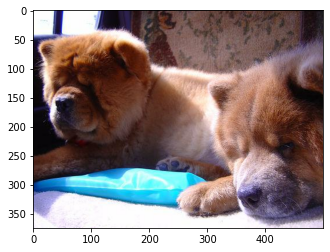

In [70]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

In [71]:
# generate_cam 함수 만들기

def generate_cam(model, item):
  item = copy.deepcopy(item)
  width = item['image'].shape[1]
  height = item['image'].shape[0]

  img_tensor, class_idx = normalize_and_resize_img(item)

  cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output])
  conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0))

  conv_outputs = conv_outputs[0, :, :, :]
  class_weights = model.layers[-1].get_weights()[0]

  cam_image = np.zeros(dtype=np.float32, shape = conv_outputs.shape[0:2])
  for i, w in enumerate(class_weights[:, class_idx]):
    cam_image += w * conv_outputs[:, :, i]

  cam_image /= np.max(cam_image)
  cam_image = cam_image.numpy()
  cam_image = cv2.resize(cam_image, (width, height))
  return cam_image

print('준비완료')

준비완료


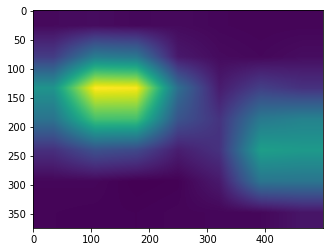

In [72]:
# CAM 생성하기

cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

In [73]:
# 원본 이미지에 CAM 이미지 합치는 함수 제작

def visualize_cam_on_image(src1, src2, alpha = 0.5):
  beta = (1.0 - alpha)
  merged_image = cv2.addWeighted(src1, alpha, src2, beta, 0.0)
  return merged_image

print('이미지 합치기 준비완료')

이미지 합치기 준비완료


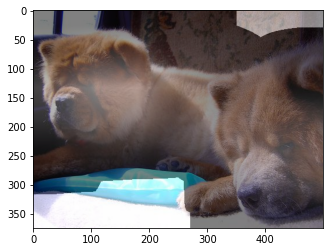

In [74]:
# 이미지 합쳐보기

origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis = -1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

### Grad-CAM 생성하기
- Grad-CAM은 관찰을 원하는 레이어와 정답 클래스에 대한 예측값 사이의 그래디언트를 구하고 여기에 GAP 연산을 적용함으로써 관찰 대상이 되는 레이어의 채널별 가중치를 구한다.
- Grad-CAM은 어떤 레이어든 CAM 이미지를 뽑아낼 수 있으므로 그래디언트 계산을 원하는 관찰 대상 레이어 activation_layer를 뽑아서 쓸 수 있도록 잘 활용해야 한다.

67


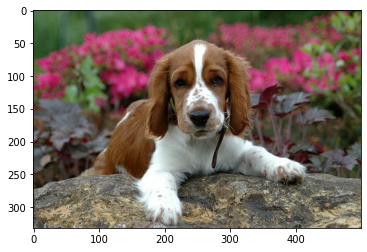

In [75]:
# 새로운 이미지 뽑아내기

item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

In [76]:
# generate_grad_cam 함수 만들기

def generate_grad_cam(model, activation_layer, item):
  item = copy.deepcopy(item)
  width = item['image'].shape[1]
  height = item['image'].shape[0]
  img_tensor, class_idx = normalize_and_resize_img(item)

  grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])

  with tf.GradientTape() as tape :
    conv_output, pred = grad_model(tf.expand_dims(img_tensor, 0))

    loss = pred[:, class_idx]
    output = conv_output[0]
    grad_val = tape.gradient(loss, conv_output)[0]
  
  weights = np.mean(grad_val, axis = (0, 1))
  grad_cam_image = np.zeros(dtype = np.float32, shape = conv_output.shape[0:2])
  for k, w in enumerate(weights):
    grad_cam_image += w * output[:, :, k]

  grad_cam_image /= np.max(grad_cam_image)
  grad_cam_image = grad_cam_image.numpy()
  grad_cam_image = cv2.resize(grad_cam_image, (width, height))
  return grad_cam_image

print('grad_cam_image 준비완료')

grad_cam_image 준비완료


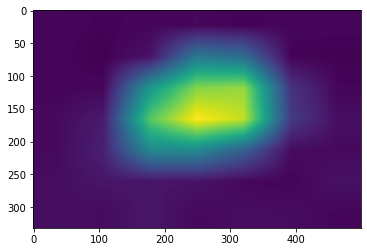

In [77]:
# Grad-CAM 이미지 뽑아보기

grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

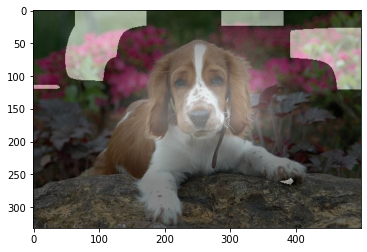

In [78]:
# 이미지 합쳐보기

origin_image = item['image'].astype(np.uint8)
grad_cam_image_3channel = np.stack([grad_cam_image*255]*3, axis = -1).astype(np.uint8)

blended_image = visualize_cam_on_image(grad_cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

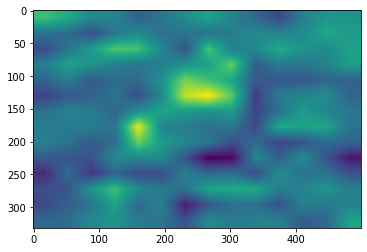

In [79]:
grad_cam_image = generate_grad_cam(cam_model, 'conv4_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

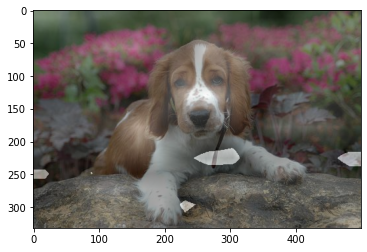

In [80]:
# 이미지 합쳐보기

origin_image = item['image'].astype(np.uint8)
grad_cam_image_3channel = np.stack([grad_cam_image*255]*3, axis = -1).astype(np.uint8)

blended_image = visualize_cam_on_image(grad_cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

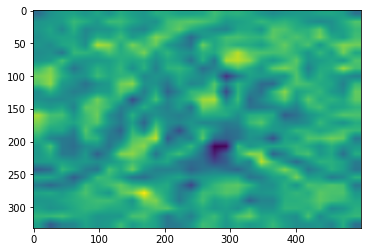

In [81]:
grad_cam_image = generate_grad_cam(cam_model, 'conv3_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

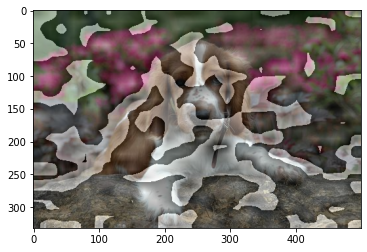

In [82]:
# 이미지 합쳐보기

origin_image = item['image'].astype(np.uint8)
grad_cam_image_3channel = np.stack([grad_cam_image*255]*3, axis = -1).astype(np.uint8)

blended_image = visualize_cam_on_image(grad_cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

### 바운딩박스 만들기

67


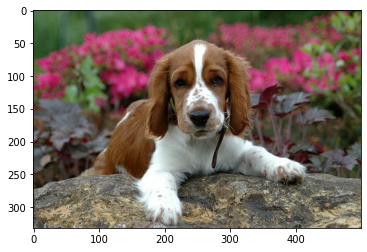

In [83]:
# 새로운 이미지 뽑기

item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

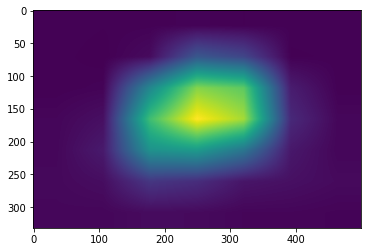

In [84]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

In [85]:
# 바운딩 박스를 만드는 함수

def get_bbox_cam(cam_image, score_thresh = 0.05):
  low_indicies = cam_image <= score_thresh
  cam_image[low_indicies] = 0
  cam_image = (cam_image * 255).astype(np.uint8)

  contours,_ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  cnt = contours[0]
  rotated_rect = cv2.minAreaRect(cnt)
  rect = cv2.boxPoints(rotated_rect)
  rect = np.int0(rect)
  return rect

print('bounding box 준비완료')

bounding box 준비완료


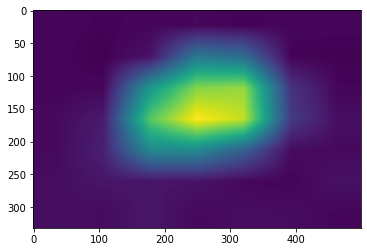

In [86]:
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

In [87]:
rect_cam = get_bbox_cam(cam_image)
rect_cam

array([[129, 334],
       [ 50,  92],
       [376, -13],
       [454, 228]])

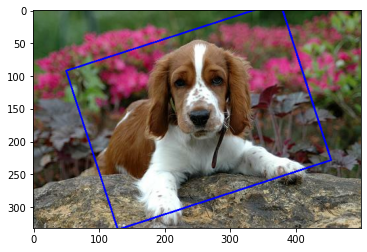

In [99]:
# CAM 방식을 사용한 바운딩 박스

image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, [rect_cam], 0, (0,0,255), 2)
plt.imshow(image)
plt.show()

In [89]:
# 바운딩 박스를 만드는 함수

def get_bbox_gradcam(grad_cam_image, score_thresh = 0.05):
  low_indicies = grad_cam_image <= score_thresh
  grad_cam_image[low_indicies] = 0
  grad_cam_image = (grad_cam_image * 255).astype(np.uint8)

  contours,_ = cv2.findContours(grad_cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  cnt = contours[0]
  rotated_rect = cv2.minAreaRect(cnt)
  rect = cv2.boxPoints(rotated_rect)
  rect = np.int0(rect)
  return rect

print('bounding box 준비완료')

bounding box 준비완료


In [90]:
rect_gradcam = get_bbox_gradcam(grad_cam_image)
rect_gradcam

array([[ 83, 258],
       [ 83,  30],
       [448,  30],
       [448, 258]])

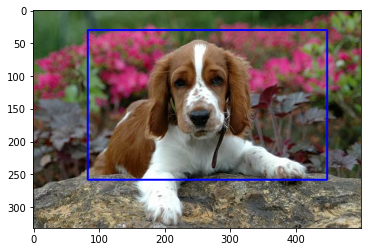

In [100]:
# Grad_CAM 방식을 사용한 바운딩 박스

image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, [rect_gradcam], 0, (0,0,255), 2)
plt.imshow(image)
plt.show()

### IoU 구하기
- IoU는 (Intersection over Union)의 줄임말로 두 영역의 교집합인 intersection 영역의 넓이를 두 영역의 합집합인 union 영역으로 나누어준 값이다.
- 이를 통해서 영역을 정확하게 잘 찾아내었는지 상대적인 비율을 구할 수 있기 때문에 모델이 영역을 잘 찾았는지 비교하는 좋은 지표로 사용이 가능하다

In [92]:
def rect_to_minmax(rect, image):
  bbox = [
          rect[:,1].min()/float(image.shape[0]),
          rect[:,0].min()/float(image.shape[1]),
          rect[:,1].max()/float(image.shape[0]),
          rect[:,0].max()/float(image.shape[1])
  ]
  return bbox

print('준비완료')

준비완료


In [93]:
# rect를 minmax(bbox)형태로 치환하기 / CAM을 이용해서 계산

pred_bbox_cam = rect_to_minmax(rect_cam, item['image'])
pred_bbox_cam

[-0.0391566265060241, 0.1, 1.0060240963855422, 0.908]

In [94]:
# ground truth bbox 확인하기

item['objects']['bbox']

array([[0.13554217, 0.146     , 0.9879518 , 0.826     ]], dtype=float32)

In [95]:
# IoU 계산하기

def get_iou(boxA, boxB):
  y_min = max(boxA[0], boxB[0])
  x_min = max(boxA[1], boxB[1])
  y_max = min(boxA[2], boxB[2])
  x_max = min(boxA[3], boxB[3])

  interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
  boxAArea = (boxA[2] - boxA[0]) * (boxA[3]- boxA[1])
  boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
  iou = interArea / float(boxAArea + boxBArea - interArea)

  return iou

print('iou 계산 준비 완료')

iou 계산 준비 완료


In [101]:
# CAM 방식을 사용한 IoU 값

get_iou(pred_bbox_cam, item['objects']['bbox'][0])

0.6863640094989136

In [97]:
# rect를 minmax(bbox)형태로 치환하기 / Grad_CAM을 이용해서 계산

pred_bbox_gradcam = rect_to_minmax(rect_gradcam, item['image'])
pred_bbox_gradcam

[0.09036144578313253, 0.166, 0.7771084337349398, 0.896]

In [102]:
# Grad_CAM 방식을 사용한 IoU 값

get_iou(pred_bbox_gradcam, item['objects']['bbox'][0])

0.6439761521014221

- CAM 방식을 통해서 얻은 IoU의 값은 0.6863이고 Grad_CAM 방식을 통해서 얻은 IoU의 값은 0.6439이다.
- 한 사진에 두마리 이상의 개가 있는 경우 IoU의 값이 0.3 수준으로 떨어지는 것을 확인하였다.

## 결과 정리

- ResNet50을 사용해서 학습이 잘 진행된 것 같다. 많은 epoch을 훈련시킨 것은 아니었지만 그래도 결과를 얻을만큼의 성능을 보여준 것 같다.
- CAM 방식과 Grad_CAM 방식을 사용해서 class activation map을 추출했을 때 object의 주요 특징 위치에 잘 반영되서 결과를 만들어낸 것 같다. 시각화를 통해서 확인했을 때도 개의 모습이 뚜렷한 곳에 활성화 된 것을 확인할 수 있었다.
- 바운딩박스 역시 활성화된 위치에 잘 잡힌 것을 확인할 수 있엇다. IoU의 값은 0.6수준이었지만 그래도 눈으로 확인했을 때는 괜찮은 결과로 보였다.
- 프로젝트를 진행하면서 겪었던 문제로는 개가 한마리 이상일 경우 CAM 결과와 IoU의 값이 많이 떨어진다는 것을 확인하였다. 여러번 다시 사진을 추출해서 진행했을 때 한 사진에 두 마리의 개가 있는 경우 IoU가 0.3 수준까지 떨어지는 것을 확인하였고 CAM 역시 한마리만 인식하는 경우가 있었다.
- 또한 프로젝트를 진행하면서 노드에서는 예시 코드를 최대한 참고하지 않고 직접 코드를 작성해보라고 하였지만 여러가지 함수들을 직접 생각해서 작성한다는 것이 매우 어려웠다.
- 결국 코드를 직접 보면서 한줄한줄 작성했는데 이해가 되는 코드들도 있고 이해가 되지 않는 코드들도 있었다.
- 하지만 복사 붙여넣기가 아닌 직접 보면서 손으로 쓰니까 좀 더 이해되는 부분이 많았던 것 같다.


## 회고

- CV 분야에서도 object detection에 관심이 있었기 때문에 이번노드를 진행하면서 지루하지 않고 재미있었던 것 같다.
- 이번노드를 진행하면서 생각외로 object detection 기술이 높은 수준으로 개발된 것을 볼 수 있었다.
- 실생활속에서도 많이 사용되고 있고 우리가 잘 알지 못하는 분야에서도 사용되는 것을 보면서 앞으로도 더 정밀하게 개발된다면 더 좋은 방향으로 사용될 수 있을 것 같다는 생각이 들었다.